<a href="https://colab.research.google.com/github/Kshitijasharma/Thermal-Battery-Predictions/blob/main/BMS_ML_to_VS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io

# Load the .mat file
mat_data = scipy.io.loadmat('B0005.mat')

# Print all keys
print("Keys in the .mat file:")
for key in mat_data.keys():
    print(key)


Keys in the .mat file:
__header__
__version__
__globals__
B0005


In [ ]:
import scipy.io
import pandas as pd

# Load the .mat file
mat_data = scipy.io.loadmat('B0005.mat')

# Access the main data struct
battery = mat_data['B0005']

# Inspect the fields inside the struct
print("Struct fields:", battery.dtype)

# Usually the data is stored like this:
# battery[0, 0]['cycle'] gives you access to cycle data
cycle_data = battery[0, 0]['cycle']

# Let's inspect the first cycle entry to understand structure
print("Cycle data dtype:", cycle_data.dtype)
print("First cycle keys:", cycle_data[0][0].dtype.names)

# Prepare to collect cycle summary data (e.g., type, capacity, etc.)
rows = []
for cycle in cycle_data[0]:
    row = {}
    for field in cycle.dtype.names:
        value = cycle[field]
        # Flatten nested values
        if value.size == 1:
            row[field] = value.item()
        else:
            row[field] = value.flatten().tolist()
    rows.append(row)

# Convert to DataFrame
df = pd.DataFrame(rows)

# Save to CSV
df.to_csv('NASA_B0005_cycles.csv', index=False)
print("Saved battery cycle summary to NASA_B0005_cycles.csv")


Struct fields: [('cycle', 'O')]
Cycle data dtype: [('type', 'O'), ('ambient_temperature', 'O'), ('time', 'O'), ('data', 'O')]
First cycle keys: ('type', 'ambient_temperature', 'time', 'data')
Saved battery cycle summary to NASA_B0005_cycles.csv


In [ ]:
import pandas as pd
import scipy.io as sio
import numpy as np

# Load the .mat file
def load_mat_file(file_name, key):
    """Loads the .mat file and extracts the specified key."""
    mat_file = sio.loadmat(file_name)
    if key not in mat_file:
        raise KeyError(f"Key '{key}' not found in the .mat file.")
    return mat_file[key]

def flatten_data(data):
    """Flattens data to ensure it is 1-dimensional."""
    return np.array(data).ravel()

def process_cycle(cycle_id, cycle_data, features_cols, cycles_cols):
    """Processes a single cycle and returns a DataFrame."""
    cycle_type = cycle_data[0]
    if cycle_type not in features_cols:
        print(f"Unknown cycle type: {cycle_type}, skipping...")
        return None

    features = features_cols[cycle_type]
    features_x_cycle = cycle_data[-1]
    tmp = pd.DataFrame()

    for feature, data in zip(features, features_x_cycle):
        flattened_data = flatten_data(data)
        tmp[feature] = pd.Series(flattened_data)

    tmp['id_cycle'] = cycle_id
    for k, col in enumerate(cycles_cols):
        tmp[col] = cycle_data[k]

    return cycle_type, tmp

def to_df(mat_db):
    """Returns one pd.DataFrame per cycle type."""
    cycles_cols = ['type', 'ambient_temperature', 'time']

    features_cols = {
        'charge': ['Voltage_measured', 'Current_measured', 'Temperature_measured',
                   'Current_charge', 'Voltage_charge', 'Time'],
        'discharge': ['Voltage_measured', 'Current_measured', 'Temperature_measured',
                      'Current_charge', 'Voltage_charge', 'Time', 'Capacity'],
        'impedance': ['Sense_current', 'Battery_current', 'Current_ratio',
                      'Battery_impedance', 'Rectified_impedance', 'Re', 'Rct']
    }

    dfs = {key: [] for key in features_cols.keys()}
    num_cycles = mat_db[0][0][0].shape[1]
    print(f'Number of cycles: {num_cycles}')
    cycles = [[row.flat[0] for row in line] for line in mat_db[0][0][0][0]]

    for cycle_id, cycle_data in enumerate(cycles):
        result = process_cycle(cycle_id, cycle_data, features_cols, cycles_cols)
        if result is not None:
            cycle_type, tmp = result
            dfs[cycle_type].append(tmp)

    return {cycle_type: pd.concat(dfs[cycle_type], ignore_index=True) for cycle_type in dfs}

# Main Execution
mat_db = load_mat_file('B0005.mat', 'B0005')
dfs = to_df(mat_db)

# Save each DataFrame to CSV
for cycle_type, df in dfs.items():
    csv_filename = f"B0005_{cycle_type}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Saved {cycle_type} data to {csv_filename}")

# Optional: Display preview of charge data
print("\nSample of charge data:")
print(dfs['charge'].head())


Number of cycles: 616
Saved charge data to B0005_charge.csv
Saved discharge data to B0005_discharge.csv
Saved impedance data to B0005_impedance.csv

Sample of charge data:
   Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.873017         -0.001201             24.655358           0.000   
1          3.479394         -4.030268             24.666480          -4.036   
2          4.000588          1.512731             24.675394           1.500   
3          4.012395          1.509063             24.693865           1.500   
4          4.019708          1.511318             24.705069           1.500   

   Voltage_charge    Time  id_cycle    type  ambient_temperature    time  
0           0.003   0.000         0  charge                   24  2008.0  
1           1.570   2.532         0  charge                   24  2008.0  
2           4.726   5.500         0  charge                   24  2008.0  
3           4.742   8.344         0  charge          

In [ ]:
discharge_df = dfs['discharge']
initial_capacity = discharge_df['Capacity'].iloc[0]
discharge_df['SOH'] = discharge_df['Capacity'] / initial_capacity

print(discharge_df)
print("Initial capacity")
print(initial_capacity)

       Voltage_measured  Current_measured  Temperature_measured  \
0              4.191492         -0.004902             24.330034   
1              4.190749         -0.001478             24.325993   
2              3.974871         -2.012528             24.389085   
3              3.951717         -2.013979             24.544752   
4              3.934352         -2.011144             24.731385   
...                 ...               ...                   ...   
50280          3.579262         -0.001569             34.864823   
50281          3.581964         -0.003067             34.814770   
50282          3.584484         -0.003079             34.676258   
50283          3.587336          0.001219             34.565580   
50284          3.589937         -0.000583             34.405920   

       Current_charge  Voltage_charge      Time  Capacity  id_cycle  \
0             -0.0006           0.000     0.000  1.856487         1   
1             -0.0006           4.206    16.781      

In [ ]:
print(discharge_df.head())          # Check first rows
print(discharge_df.columns)         # Check columns, especially 'Capacity' and 'id_cycle'
print(discharge_df['Capacity'].describe())  # Summary stats to ensure 'Capacity' has data


   Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          4.191492         -0.004902             24.330034         -0.0006   
1          4.190749         -0.001478             24.325993         -0.0006   
2          3.974871         -2.012528             24.389085         -1.9982   
3          3.951717         -2.013979             24.544752         -1.9982   
4          3.934352         -2.011144             24.731385         -1.9982   

   Voltage_charge    Time  Capacity  id_cycle       type  ambient_temperature  \
0           0.000   0.000  1.856487         1  discharge                   24   
1           4.206  16.781       NaN         1  discharge                   24   
2           3.062  35.703       NaN         1  discharge                   24   
3           3.030  53.781       NaN         1  discharge                   24   
4           3.011  71.922       NaN         1  discharge                   24   

     time  SOH  
0  2008.0  1.0  
1  2

In [ ]:
features = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'cycle_number']
combined_df = discharge_df[features + ['SOH', 'RUL']].dropna()

X = combined_df[features]
y_soh = combined_df['SOH']
y_rul = combined_df['RUL']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split
X_train, X_test, y_soh_train, y_soh_test = train_test_split(X, y_soh, test_size=0.2, random_state=42)
_, _, y_rul_train, y_rul_test = train_test_split(X, y_rul, test_size=0.2, random_state=42)

# SOH Model
soh_model = RandomForestRegressor()
soh_model.fit(X_train, y_soh_train)
soh_preds = soh_model.predict(X_test)

print("SOH MAE:", mean_absolute_error(y_soh_test, soh_preds))
print("SOH R2:", r2_score(y_soh_test, soh_preds))

# RUL Model
rul_model = RandomForestRegressor()
rul_model.fit(X_train, y_rul_train)
rul_preds = rul_model.predict(X_test)

print("RUL MAE:", mean_absolute_error(y_rul_test, rul_preds))
print("RUL R2:", r2_score(y_rul_test, rul_preds))

SOH MAE: 0.0051297944969226125
SOH R2: 0.9957429409943783
RUL MAE: 0.6900000000000003
RUL R2: 0.9996922244632676


Predicting temperature using ARIMA

Using LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


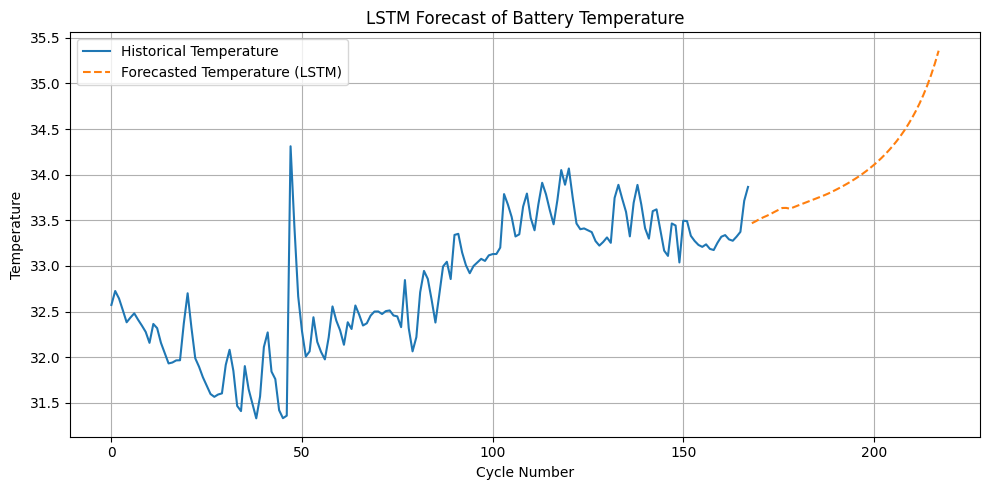

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load data
df = pd.read_csv('B0005_discharge.csv')
df = df[['id_cycle', 'Temperature_measured']].dropna()

# Group by cycle and take average temperature
temp_series = df.groupby('id_cycle')['Temperature_measured'].mean().values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler()
scaled_temp = scaler.fit_transform(temp_series)

# Create sequences for training (sliding window)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(scaled_temp, window_size)

# Reshape input to [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=0)

# Forecast next 50 temperatures
n_future = 50
seed_sequence = scaled_temp[-window_size:].reshape(1, window_size, 1)

predictions = []
for _ in range(n_future):
    pred = model.predict(seed_sequence, verbose=0)[0][0]
    predictions.append(pred)
    # Update seed sequence with new prediction
    seed_sequence = np.append(seed_sequence[:, 1:, :], [[[pred]]], axis=1)

# Inverse scale predictions
predicted_temps = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot
past_temps = temp_series.flatten()
future_index = range(len(past_temps), len(past_temps) + n_future)

plt.figure(figsize=(10, 5))
plt.plot(range(len(past_temps)), past_temps, label="Historical Temperature")
plt.plot(future_index, predicted_temps.flatten(), '--', label="Forecasted Temperature (LSTM)")
plt.xlabel("Cycle Number")
plt.ylabel("Temperature")
plt.title("LSTM Forecast of Battery Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Print future predictions
print("\nForecasted Temperature for Next 50 Cycles:")
start_cycle = len(temp_series)
for i, temp in enumerate(predicted_temps.flatten()):
    print(f"Cycle {start_cycle + i}: {temp:.2f} °C")


Forecasted Temperature for Next 50 Cycles:
Cycle 168: 33.47 °C
Cycle 169: 33.49 °C
Cycle 170: 33.51 °C
Cycle 171: 33.53 °C
Cycle 172: 33.55 °C
Cycle 173: 33.57 °C
Cycle 174: 33.59 °C
Cycle 175: 33.61 °C
Cycle 176: 33.63 °C
Cycle 177: 33.64 °C
Cycle 178: 33.63 °C
Cycle 179: 33.64 °C
Cycle 180: 33.66 °C
Cycle 181: 33.68 °C
Cycle 182: 33.69 °C
Cycle 183: 33.71 °C
Cycle 184: 33.72 °C
Cycle 185: 33.74 °C
Cycle 186: 33.76 °C
Cycle 187: 33.77 °C
Cycle 188: 33.79 °C
Cycle 189: 33.81 °C
Cycle 190: 33.83 °C
Cycle 191: 33.85 °C
Cycle 192: 33.88 °C
Cycle 193: 33.90 °C
Cycle 194: 33.93 °C
Cycle 195: 33.95 °C
Cycle 196: 33.98 °C
Cycle 197: 34.01 °C
Cycle 198: 34.04 °C
Cycle 199: 34.07 °C
Cycle 200: 34.11 °C
Cycle 201: 34.14 °C
Cycle 202: 34.18 °C
Cycle 203: 34.22 °C
Cycle 204: 34.27 °C
Cycle 205: 34.32 °C
Cycle 206: 34.37 °C
Cycle 207: 34.42 °C
Cycle 208: 34.48 °C
Cycle 209: 34.55 °C
Cycle 210: 34.62 °C
Cycle 211: 34.70 °C
Cycle 212: 34.78 °C
Cycle 213: 34.87 °C
Cycle 214: 34.98 °C
Cycle 215: 35.09

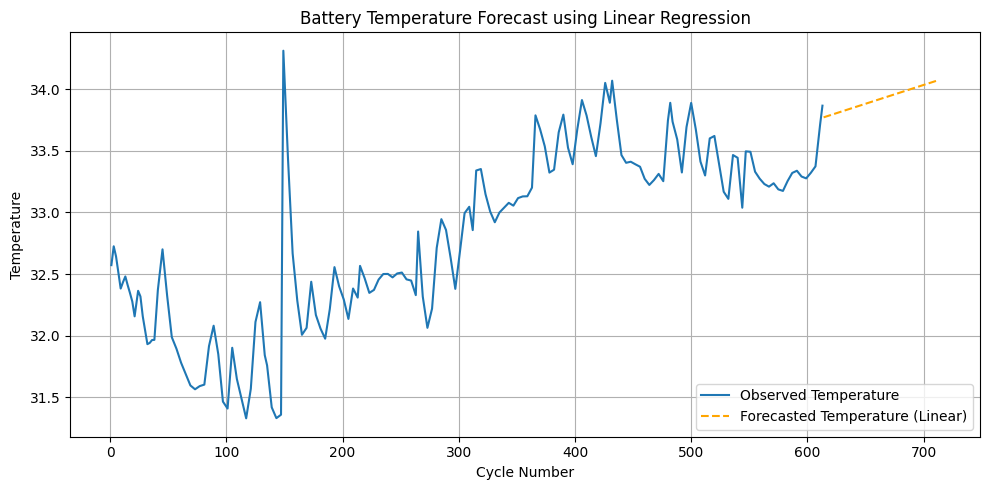

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load and preprocess data
df = pd.read_csv("B0005_discharge.csv")
df = df[['id_cycle', 'Temperature_measured']].dropna()

# Group by cycle and compute average temperature per cycle
grouped_df = df.groupby('id_cycle')['Temperature_measured'].mean().reset_index()

# Features and target
X = grouped_df[['id_cycle']]
y = grouped_df['Temperature_measured']

# Train Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict future temperature for next 100 cycles
last_cycle = X['id_cycle'].max()
future_cycles = pd.DataFrame({'id_cycle': range(last_cycle + 1, last_cycle + 101)})
future_preds = model.predict(future_cycles)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(X['id_cycle'], y, label='Observed Temperature')
plt.plot(future_cycles['id_cycle'], future_preds, '--', label='Forecasted Temperature (Linear)', color='orange')
plt.xlabel('Cycle Number')
plt.ylabel('Temperature')
plt.title('Battery Temperature Forecast using Linear Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
